WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


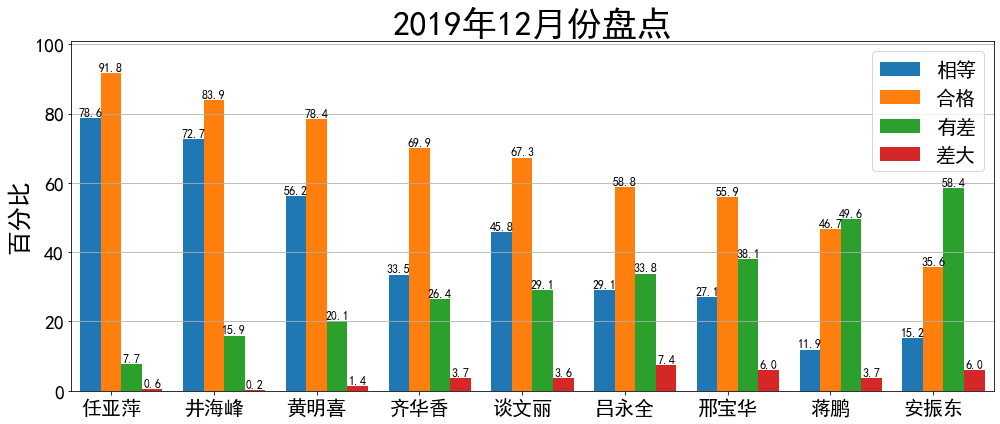

In [71]:
#盘点数据分析V0.1
#%%writefile 'analysisdata.py'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os


def getResult(x):
    if(x.结存_x==x.结存_y):
        return '相等'
    elif((x.盘点差>=-0.15) & (x.盘点差<0.05)):
        return '合格'
    elif(((x.盘点差>=-1.5) & (x.盘点差<-0.15)) | ((x.盘点差>=0.05) & (x.盘点差<1))):
        return '有差'
    elif((x.盘点差<-1.5) | (x.盘点差>=1)):
        return '差大'
    
pd.set_option('max_columns', 20)
pd.set_option('max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # 禁用科学计数法
#pd.set_option('display.max_rows',None)

#打开文件
spath = r'I:\\#Data\\2020\\01\\04\\'
df_ERP_output_stock1 = pd.read_excel(spath+'限额领料单列表.XLS',usecols=[2,3,6,4]).fillna(0)
#df_ERP_output_stock2 = pd.read_excel(r'I:\\#Data\\201912\\20191228\\1限额领料单列表.XLS',usecols=[2,3,4,6]).fillna(0)
df_bar_output_stock1 = pd.read_excel(spath+'领料出库单列表.XLSx',usecols=[6,10]).fillna(0)
df_erp_inv = pd.read_excel(spath+'库存展望.XLS',usecols=[6,7,8,9,10,11]).fillna(0)
df_erp_inv = df_erp_inv[df_erp_inv['现存量']>0]
df_bar_inv = pd.read_excel(spath+'库存汇总表.xlsx',usecols=[0,6])
#df_stagnate = pd.read_excel(r'I:\\#Data\\201912\\20191228\\盘点完成.xlsx',usecols=[0,4,7])
#df_inv_check = pd.read_excel(r'I:\\#Data\\201912\\20191228\\库存盘点单列表.xlsx',usecols=[0,1,2,4,5,6,7,8,9])
#df_erp_inv=df_erp_inv.iloc[0:10]
df11 = pd.pivot_table(df_ERP_output_stock1,values='计划出库数量',index='材料编码',aggfunc='sum')
#df12 = pd.pivot_table(df_ERP_output_stock2,values='计划出库数量',index='材料编码',aggfunc='sum')
    
#df1是ERP结存
df1 = pd.merge(df_erp_inv,df11,left_on='存货编码',right_on='材料编码',how='left').fillna(0)
#df1 = pd.merge(df1,df12,left_on='存货编码',right_on='材料编码',how='left').fillna(0)
#print(df1)
#df1['现存量']=df1['现存量'].astype('float')
#df1['结存'] = df1.apply(lambda x:x.现存量-x.计划出库数量_x-x.计划出库数量_y,axis=1)

#df1['结存'] = df1.apply(lambda x:x.现存量-x.计划出库数量,axis=1)
df1['结存'] = df1.apply(lambda x:x.现存量,axis=1)

#########################################################################
    
#1月份出库合计
df21 =pd.pivot_table(df_bar_output_stock1,values='计划数量',index='资材编号',aggfunc='sum')
    
#12月份条码结存
df2 = pd.merge(df_bar_inv,df21,on='资材编号',how='left').fillna(0)
df2['结存'] = df2.apply(lambda x:x.期末数量+x.计划数量,axis=1)
    
##########################################################################
df = pd.merge(df1,df2,left_on='存货编码',right_on='资材编号',how='inner')
#df = pd.merge(df0,df_stagnate,on='存货编码',how='left').fillna(0)
#df['出库率'] = df.apply(lambda x:'高' if((x.计划出库数量_x+x.计划出库数量_y)>0) else '低',axis=1)
df['出库率'] = df.apply(lambda x:'高' if(x.计划出库数量>0) else '低',axis=1)
df['盘点差'] = df.apply(lambda x:0 if(x.结存_x==0) else (x.结存_x-x.结存_y)/x.结存_x,axis=1)
df['结论'] = df.apply(lambda x:getResult(x),axis=1)
df.to_excel('盘点数据.xlsx')
#df=df[df['现存量']>0]
#选择数据后，不能进行数据透视表操作
#df = df[['存货编码','存货名称','规格型号','单位','库管员','结存_x','结存_y','出库率','盘点差','现存量_y','类别','结论']]

###########################################################################
df = df.pivot_table(index='库管员',columns='结论',values='资材编号',aggfunc='count',margins=True,margins_name='合计')
#计算百分比
df['合格A1']=df.apply(lambda x:x.合格/x.合计*100,axis=1)
df['差大A']=df.apply(lambda x:x.差大/x.合计*100,axis=1)
df['有差A']=df.apply(lambda x:x.有差/x.合计*100,axis=1)
df['相等A']=df.apply(lambda x:x.相等/x.合计*100,axis=1)
df['合格A']=df.apply(lambda x:x.合格A1+x.相等A,axis=1)
#df.sort_values(by=['合格A'],ascending=True)

df.reset_index()
df = df[0:9].sort_values(by=['合格A'],ascending=False)
#print(df)
##############################################################################
#绘制图表--数据可视化
plt.figure(figsize=(14,6))
plt.rcParams['font.sans-serif']='SimHei'
plt.subplot(1,1,1,xmargin=0.01,ymargin=0.1)

#x = ['井海峰','蒋鹏','黄明喜','吕永全','齐华香','任亚萍','谈文丽','安振东','邢宝桦']
x = np.array([1,2,3,4,5,6,7,8,9])
#y1 = np.array([108,150,138,119,212,188,117,174,205])
#y2 = np.array([108,150,138,119,212,188,117,174,205])
y1 = np.array(list(df['相等A'][0:9]))
y2 = np.array(list(df['合格A'][0:9]))
y3 = np.array(list(df['有差A'][0:9]))
y4 = np.array(list(df['差大A'][0:9]))
plt.bar(x,y1,width=0.2,label="相等")
plt.bar(x+0.2,y2,width=0.2,label="合格")
plt.bar(x+0.4,y3,width=0.2,label="有差")
plt.bar(x+0.6,y4,width=0.2,label="差大")

#设置数据标签
for a,b in zip(x,y1):
    plt.text(a,b,round(b,1),ha='center',va='bottom',fontsize=12)
for a,b in zip(x,y2):
    plt.text(a+0.2,b,round(b,1),ha='center',va='bottom',fontsize=12)
for a,b in zip(x,y3):
    plt.text(a+0.4,b,round(b,1),ha='center',va='bottom',fontsize=12)
for a,b in zip(x,y4):
    plt.text(a+0.6,b,round(b,1),ha='center',va='bottom',fontsize=12)
plt.legend(fontsize=20)
#plt.xlabel('姓名',fontsize=15,labelpad=1)
plt.ylabel('百分比',fontsize=25)
plt.yticks(fontsize=20)
#list_index = ['任亚萍','井海峰','黄明喜','谈文丽','齐华香','邢宝桦','吕永全','蒋鹏','安振东']
list_index = df.index.tolist()
plt.xticks(x+0.2,list_index,fontsize=20) #,rotation=12
plt.title(label='2019年12月份盘点',fontsize=35)
plt.grid(b=True,axis='y') 
plt.subplots_adjust(left=0,bottom=0,right=1,top=10,wspace=5,hspace=55)
plt.tight_layout()
plt.savefig('盘点结果.jpg')

In [11]:
df.index.tolist()

['任亚萍', '井海峰', '黄明喜', '齐华香', '谈文丽', '吕永全', '邢宝华', '蒋鹏', '安振东']

            存货编码 存货信息存货名称      存货信息规格型号 存货信息主计量单位      现存量  库管员  计划出库数量
0     BF00C50001    铁氧体磁芯     W-W02228A       PCS    20.00  黄明喜    0.00
1     BF26M00050    底漆稀释剂            HK        KG    16.00   蒋鹏    0.00
2     BF26M00051     米黄面漆        PC2000        KG    18.00   蒋鹏    0.00
3     BF26M00052     灰色底漆  UNIGROUND930        KG   102.00   蒋鹏    0.00
4     BF26M00053      固化剂        PC2000        KG     3.60   蒋鹏    0.00
...          ...      ...           ...       ...      ...  ...     ...
6463  TT79B31028   螺母(TY)      U4167F03       PCS    10.00  谈文丽    0.00
6464  TT79E00805      开关盖      U2853C05       PCS 18276.00  谈文丽    0.00
6465  TTY3763C01       夹管      Y3763C01       PCS   400.00  谈文丽    0.00
6466  TTY3764C01       夹管      Y3764C01       PCS   400.00  谈文丽    0.00
6467  TTY3764C21    焊枪体支架      Y3764C21       PCS   400.00  谈文丽    0.00

[6468 rows x 7 columns]
结论    合格  差大   有差   相等   合计  合格A1  差大A   有差A   相等A   合格A
库管员                                                   

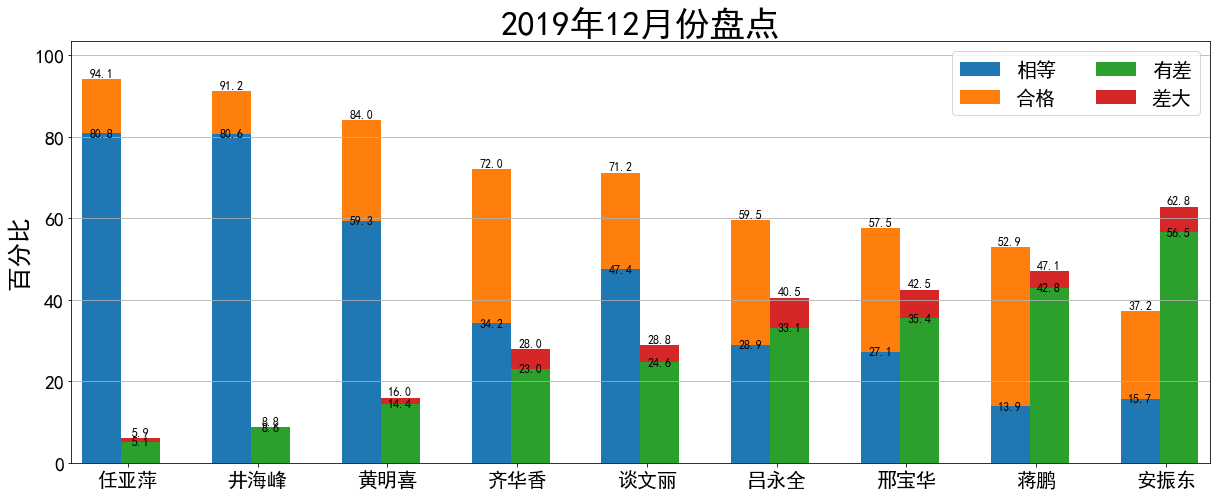

In [90]:
#盘点数据分析V0.2
#%%writefile 'analysisdata_202001060914.py'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os


def getResult(x):
    if(x.结存_x==x.结存_y):
        return '相等'
    elif((x.盘点差>=-0.15) & (x.盘点差<0.05) & (x.结存_x!=x.结存_y)):
        return '合格'
    elif(((x.盘点差>=-1.5) & (x.盘点差<-0.15)) | ((x.盘点差>=0.05) & (x.盘点差<1))):
        return '有差'
    elif((x.盘点差<-1.5) | (x.盘点差>=1)):
        return '差大'

#设置pandas
pd.set_option('max_columns', 20)
pd.set_option('max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # 禁用科学计数法
#pd.set_option('display.max_rows',None)

#打开Excel文件【pd.read_excel(path,usecols)】
spath = r'I:\\#Data\\2020\\01\\04\\'
df_ERP_output_stock1 = pd.read_excel(spath+'限额领料单列表.XLS',usecols=[2,3,6,4]).fillna(0)
df_bar_output_stock1 = pd.read_excel(spath+'领料出库单列表.XLSx',usecols=[6,10]).fillna(0)
df_erp_inv = pd.read_excel(spath+'库存展望.XLS',usecols=[6,7,8,9,10,11]).fillna(0)
df_erp_inv = df_erp_inv[df_erp_inv['现存量']>0]
df_bar_inv = pd.read_excel(spath+'库存汇总表.xlsx',usecols=[0,6])
df_bar_inv = pd.pivot_table(df_bar_inv,values='期末数量',index='资材编号',aggfunc='sum').reset_index()

#通过数据透视表计算月份出库合计【pd.pivot_table】
df11 = pd.pivot_table(df_ERP_output_stock1,values='计划出库数量',index='材料编码',aggfunc='sum')
df21 =pd.pivot_table(df_bar_output_stock1,values='计划数量',index='资材编号',aggfunc='sum')
 
#连接库存和出库数据表计算库存【pd.merge】
df1 = pd.merge(df_erp_inv,df11,left_on='存货编码',right_on='材料编码',how='left').fillna(0)
print(df1)
#df1['现存量']=df1['现存量'].astype('float')
df1['结存'] = df1.apply(lambda x:x.现存量-x.计划出库数量,axis=1)
df2 = pd.merge(df_bar_inv,df21,on='资材编号',how='left').fillna(0)
df2['结存'] = df2.apply(lambda x:x.期末数量+x.计划数量,axis=1)
    
#连接ERP结存和条码结存计算盘点相关结论
df = pd.merge(df1,df2,left_on='存货编码',right_on='资材编号',how='inner')
#df = pd.merge(df0,df_stagnate,on='存货编码',how='left').fillna(0)
df['出库率'] = df.apply(lambda x:'高' if(x.计划出库数量>0) else '低',axis=1)
df['盘点差'] = df.apply(lambda x:0 if(x.结存_x==0) else (x.结存_x-x.结存_y)/x.结存_x,axis=1)
df['结论'] = df.apply(lambda x:getResult(x),axis=1)
#print(df11)
#print(df1)
#print(df2)
#print(df)
df0=df
###########################################################################
df = df.pivot_table(index='库管员',columns='结论',values='资材编号',aggfunc='count',margins=True,margins_name='合计')
#计算百分比
#柱状图
#df['合格A1']=df.apply(lambda x:x.合格/x.合计*100,axis=1)
#df['差大A']=df.apply(lambda x:x.差大/x.合计*100,axis=1)
#df['有差A']=df.apply(lambda x:x.有差/x.合计*100,axis=1)
#df['相等A']=df.apply(lambda x:x.相等/x.合计*100,axis=1)
#df['合格A']=df.apply(lambda x:x.合格A1+x.相等A,axis=1)

#堆积图
df['合格A1']=df.apply(lambda x:x.合格/x.合计*100,axis=1)
df['差大A']=df.apply(lambda x:x.差大/x.合计*100,axis=1)
df['有差A']=df.apply(lambda x:x.有差/x.合计*100,axis=1)
df['相等A']=df.apply(lambda x:x.相等/x.合计*100,axis=1)
df['合格A']=df.apply(lambda x:x.合格A1+x.相等A,axis=1)


df.reset_index()
df = df[0:9].sort_values(by=['合格A'],ascending=False)
print(df)
#df.to_excel(r'd:\堆积图数据.xlsx')
#################################### 绘制图表--数据可视化 ########################################
plt.figure(figsize=(17,7))
plt.rcParams['font.sans-serif']='SimHei'
plt.subplot(1,1,1,xmargin=0.01,ymargin=0.1)

x = np.arange(1,10)
y1 = np.array(list(df['相等A'][0:9]))
y2 = np.array(list(df['合格A1'][0:9]))
y3 = np.array(list(df['有差A'][0:9]))
y4 = np.array(list(df['差大A'][0:9]))

#柱状图
#plt.bar(x,y1,width=0.2,label="相等")
#plt.bar(x+0.2,y2,width=0.2,label="合格")
#plt.bar(x+0.4,y3,width=0.2,label="有差")
#plt.bar(x+0.6,y4,width=0.2,label="差大")
#堆积图
plt.bar(x,y1,width=0.3,label="相等")
plt.bar(x,y2,width=0.3,bottom=y1,label="合格")
plt.bar(x+0.3,y3,width=0.3,label="有差")
plt.bar(x+0.3,y4,width=0.3,bottom=y3,label="差大")

#设置数据标签
for a,b in zip(x,y1):
    plt.text(a,b,round(b,1),ha='center',va='center',fontsize=12)
for a,b in zip(x,y2+y1):
    plt.text(a,b,round(b,1),ha='center',va='bottom',fontsize=12)
for a,b in zip(x,y3):
    plt.text(a+0.3,b,round(b,1),ha='center',va='center',fontsize=12)
for a,b in zip(x,y4+y3):
    plt.text(a+0.3,b,round(b,1),ha='center',va='bottom',fontsize=12)
plt.legend(ncol=2,fontsize=20)

plt.ylabel('百分比',fontsize=25)
plt.yticks(fontsize=20)

list_index = df.index.tolist()
plt.xticks(x+0.2,list_index,fontsize=20) #,rotation=12
plt.title(label='2019年12月份盘点',fontsize=35)
plt.grid(b=True,axis='y') 
plt.subplots_adjust(left=0,bottom=0,right=1,top=10,wspace=5,hspace=55)
plt.tight_layout()
'''
cellText = [
    np.round(y1,1).tolist(),
    np.round(y2,1).tolist(),
    np.round(y3,1).tolist(),
    np.round(y4,1).tolist()
]
rows=df.index.tolist()
columns=df.columns.tolist()
table=plt.table(
    cellText = cellText,
    rowLabels = columns[0:4],
    colWidths = [0.1]*9,
    #cellHeights = [0.2]*5,
    colLabels = rows,
)
table.set_fontsize(20)
table.scale(1,1)
'''
plt.savefig('盘点结果.jpg')
plt.show()

In [91]:
cellText = [
    np.round(y1,1).tolist(),
    np.round(y2,1).tolist(),
    np.round(y3,1).tolist(),
    np.round(y4,1).tolist()
]
cellText
#rows=df.index.tolist()
#columns=df.columns.tolist()
#columns[0:4]

#round(y1.tolist(),1)

#np.round(y1,1)
df0.to_excel(r'D:\#条形码系统\盘点\#盘点资料\201912\2019年12月份盘点表202001061526.xlsx')
pd.set_option('display.max_rows',None)
#df_bar_inv

#df21.to_excel(r'D:\#条形码系统\盘点\#盘点资料\201912\条码结存202001061449.xlsx')

In [66]:
plt.show()

In [3]:
#盘点数据分析V0.3
#%%writefile 'analysisdata_202001071040.py'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os


def getResult(x):
    if(x.结存_x==x.结存_y):
        return '相等'
    elif((x.盘点差>=-0.15) & (x.盘点差<0.05) & (x.结存_x!=x.结存_y)):
        return '合格'
    elif(((x.盘点差>=-1.5) & (x.盘点差<-0.15)) | ((x.盘点差>=0.05) & (x.盘点差<1))):
        return '有差'
    elif((x.盘点差<-1.5) | (x.盘点差>=1)):
        return '差大'

#设置pandas
pd.set_option('max_columns', 20)
pd.set_option('max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # 禁用科学计数法
#pd.set_option('display.max_rows',None)

#打开Excel文件【pd.read_excel(path,usecols)】
spath = r'I:\\#Data\\2020\\01\\04\\'
df_ERP_output_stock1 = pd.read_excel(spath+'限额领料单列表.XLS',usecols=[2,3,6,4]).fillna(0)
df_bar_output_stock1 = pd.read_excel(spath+'领料出库单列表.XLSx',usecols=[6,10]).fillna(0)
df_erp_inv = pd.read_excel(spath+'库存展望.XLS',usecols=[6,7,8,9,10,11]).fillna(0)
df_erp_inv = df_erp_inv[df_erp_inv['现存量']>0]
df_bar_inv = pd.read_excel(spath+'库存汇总表.xlsx',usecols=[0,6])
df_bar_inv = pd.pivot_table(df_bar_inv,values='期末数量',index='资材编号',aggfunc='sum').reset_index()

#通过数据透视表计算月份出库合计【pd.pivot_table】
df11 = pd.pivot_table(df_ERP_output_stock1,values='计划出库数量',index='材料编码',aggfunc='sum')
df21 =pd.pivot_table(df_bar_output_stock1,values='计划数量',index='资材编号',aggfunc='sum')
 
#连接库存和出库数据表计算库存【pd.merge】
df1 = pd.merge(df_erp_inv,df11,left_on='存货编码',right_on='材料编码',how='left').fillna(0)
print(df1)
#df1['现存量']=df1['现存量'].astype('float')
df1['结存'] = df1.apply(lambda x:x.现存量-x.计划出库数量,axis=1)
df2 = pd.merge(df_bar_inv,df21,on='资材编号',how='left').fillna(0)
df2['结存'] = df2.apply(lambda x:x.期末数量+x.计划数量,axis=1)
    
#连接ERP结存和条码结存计算盘点相关结论
df = pd.merge(df1,df2,left_on='存货编码',right_on='资材编号',how='inner')
#df = pd.merge(df0,df_stagnate,on='存货编码',how='left').fillna(0)
df['出库率'] = df.apply(lambda x:'高' if(x.计划出库数量>0) else '低',axis=1)
df['盘点差'] = df.apply(lambda x:0 if(x.结存_x==0) else (x.结存_x-x.结存_y)/x.结存_x,axis=1)
df['结论'] = df.apply(lambda x:getResult(x),axis=1)
#print(df11)
#print(df1)
#print(df2)
#print(df)
df0=df
###########################################################################
df = df.pivot_table(index='库管员',columns='结论',values='资材编号',aggfunc='count',margins=True,margins_name='合计')
#计算百分比
#柱状图
#df['合格A1']=df.apply(lambda x:x.合格/x.合计*100,axis=1)
#df['差大A']=df.apply(lambda x:x.差大/x.合计*100,axis=1)
#df['有差A']=df.apply(lambda x:x.有差/x.合计*100,axis=1)
#df['相等A']=df.apply(lambda x:x.相等/x.合计*100,axis=1)
#df['合格A']=df.apply(lambda x:x.合格A1+x.相等A,axis=1)

#堆积图
df['合格A1']=df.apply(lambda x:x.合格/x.合计*100,axis=1)
df['差大A']=df.apply(lambda x:x.差大/x.合计*100,axis=1)
df['有差A']=df.apply(lambda x:x.有差/x.合计*100,axis=1)
df['相等A']=df.apply(lambda x:x.相等/x.合计*100,axis=1)
df['合格A']=df.apply(lambda x:x.合格A1+x.相等A,axis=1)


df.reset_index()
df = df[0:9].sort_values(by=['合格A'],ascending=False)
print(df)
#df.to_excel(r'd:\堆积图数据.xlsx')
#################################### 绘制图表--数据可视化 ########################################
plt.figure(figsize=(17,7))
plt.rcParams['font.sans-serif']='SimHei'
plt.subplot(1,1,1,xmargin=0.01,ymargin=0.1)

x = np.arange(1,10)
y1 = np.array(list(df['相等A'][0:9]))
y2 = np.array(list(df['合格A1'][0:9]))
y3 = np.array(list(df['有差A'][0:9]))
y4 = np.array(list(df['差大A'][0:9]))

#柱状图
#plt.bar(x,y1,width=0.2,label="相等")
#plt.bar(x+0.2,y2,width=0.2,label="合格")
#plt.bar(x+0.4,y3,width=0.2,label="有差")
#plt.bar(x+0.6,y4,width=0.2,label="差大")
#堆积图
plt.bar(x,y1,width=0.3,label="相等")
plt.bar(x,y2,width=0.3,bottom=y1,label="合格")
plt.bar(x+0.3,y3,width=0.3,label="有差")
plt.bar(x+0.3,y4,width=0.3,bottom=y3,label="差大")

#设置数据标签
for a,b in zip(x,y1):
    plt.text(a,b,round(b,1),ha='center',va='center',fontsize=12)
for a,b in zip(x,y2+y1):
    plt.text(a,b,round(b,1),ha='center',va='bottom',fontsize=12)
for a,b in zip(x,y3):
    plt.text(a+0.3,b,round(b,1),ha='center',va='center',fontsize=12)
for a,b in zip(x,y4+y3):
    plt.text(a+0.3,b,round(b,1),ha='center',va='bottom',fontsize=12)
plt.legend(ncol=2,fontsize=20)

plt.ylabel('百分比',fontsize=25)
plt.yticks(fontsize=20)

list_index = df.index.tolist()
plt.xticks(x+0.2,list_index,fontsize=20) #,rotation=12
plt.title(label='2019年12月份盘点',fontsize=35)
plt.grid(b=True,axis='y') 
plt.subplots_adjust(left=0,bottom=0,right=1,top=10,wspace=5,hspace=55)
plt.tight_layout()

plt.savefig('盘点结果.jpg')
plt.show()

            存货编码 存货信息存货名称      存货信息规格型号 存货信息主计量单位      现存量  库管员  计划出库数量
0     BF00C50001    铁氧体磁芯     W-W02228A       PCS    20.00  黄明喜    0.00
1     BF26M00050    底漆稀释剂            HK        KG    16.00   蒋鹏    0.00
2     BF26M00051     米黄面漆        PC2000        KG    18.00   蒋鹏    0.00
3     BF26M00052     灰色底漆  UNIGROUND930        KG   102.00   蒋鹏    0.00
4     BF26M00053      固化剂        PC2000        KG     3.60   蒋鹏    0.00
...          ...      ...           ...       ...      ...  ...     ...
6463  TT79B31028   螺母(TY)      U4167F03       PCS    10.00  谈文丽    0.00
6464  TT79E00805      开关盖      U2853C05       PCS 18276.00  谈文丽    0.00
6465  TTY3763C01       夹管      Y3763C01       PCS   400.00  谈文丽    0.00
6466  TTY3764C01       夹管      Y3764C01       PCS   400.00  谈文丽    0.00
6467  TTY3764C21    焊枪体支架      Y3764C21       PCS   400.00  谈文丽    0.00

[6468 rows x 7 columns]
结论    合格  差大   有差   相等   合计  合格A1  差大A   有差A   相等A   合格A
库管员                                                   

<Figure size 1700x700 with 1 Axes>

In [5]:
#导出到Excel
df0.to_excel(excel_writer=r'I:/盘点表202001071045.xlsx')

In [ ]:
plt.figure(figsize=(17,25))
plt.rcParams['font.sans-serif']='SimHei'
#person = ['井海峰','蒋鹏','黄明喜','吕永全','齐华香','任亚萍','谈文丽','安振东','邢宝桦']
i=0
for p in person:
    i = i + 1
    plt.subplot(5,2,i,xmargin=0.01,ymargin=0.1)
    x = df3['日期']
    y = df3[p]
    plt.bar(x,y,label="件数")
    plt.legend(fontsize=12)
    plt.xlabel('日期',fontsize=13,labelpad=1)
    plt.ylabel('件数',fontsize=13)
    #plt.xtick(rotation=12)
    plt.title(label='['+p+']12月份盘点件数',fontsize=20)
    
plt.subplots_adjust(left=0,bottom=0,right=1,top=10,wspace=5,hspace=55)
plt.tight_layout()
#plt.savefig('test181518.jpg')
